In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
raw_covid = pd.read_csv("jrc-covid-19-world-latest.csv")
gini_data = pd.read_csv("gini_data2.csv")
gdp_data = pd.read_csv("gdp_data.csv")
pop_data = pd.read_csv("API_SP.POP.TOTL_DS2_en_csv_v2_2106202.csv")
pop_den = pd.read_csv("pop_density.csv")
unemploy_rates = pd.read_csv("unemployment_rates.csv")

In [3]:
gdp_data.columns = gdp_data.loc[3]
gdp_data = gdp_data.drop(index = [0,1,2,3])

In [4]:
new_colnames = [i.lower() for i in raw_covid.columns]
covid_cases = raw_covid.copy()
for i in covid_cases.columns:
    covid_cases.columns = new_colnames
    
#dropping unnecessary columns:
covid_cases = covid_cases[['date', 'iso3', 'continent', 'countryname'
                           , 'cumulativepositive', 'cumulativedeceased'
                           , 'currentlypositive']]
#renaming columns
covid_cases.rename(columns = {'iso3':'country_code','countryname':'country_name'
                              , 'cumulativepositive':'cumulative_pos', 'cumulativedeceased':'cumulative_dec'
                              , 'currentlypositive':'curr_pos'}, inplace = True)



#clean gdp data, drop unecessary columns and rename them
new_colnames = []
gdp = gdp_data.copy()
gdp.rename(columns = {"Country Name":"country_name","Country Code":"country_code",2019:"gdp_per_cap"}
           , inplace = True)
gdp = gdp[["country_name","country_code","gdp_per_cap"]]

#drop NaNs in gdp
gdp = gdp.dropna(axis = 0,subset=["gdp_per_cap"])

#clean gini column names
gini_data.rename(columns = {"Country Code":"country_code",
                          "Country":"country","Value":"gini_index",'Year':"gini_year"},inplace = True)

#clean population data
pop_data.rename(columns = {"Country Code":"country_code","Country Name":"country_name","2019":"population"}
                ,inplace = True)
pop_data = pop_data[["country_code",'country_name','population']]

#clean population density 
pop_den.rename(columns = {"Country Code":"country_code","Country Name":"country_name","2018":"density"}
               ,inplace = True)
pop_den = pop_den[['country_code','country_name','density']]

#clean unemployment rates 
unemploy_rates.rename(columns = {"Country Code":"country_code","Country Name":"country_name","2019":"rates"}
                      ,inplace = True)
unemploy_rates = unemploy_rates[['country_code','country_name','rates']]


In [5]:
#adding gdp 
covid_gdp = pd.merge(left = covid_cases, right = gdp, left_on = "country_code",right_on = "country_code")
print(len(covid_gdp))

#adding gini
covid_gdp_gini = pd.merge(left = covid_gdp, right = gini_data, left_on = "country_code",right_on = "country_code")
print(len(covid_gdp_gini))

#adding population 
covid_gdp_gini = pd.merge(left = covid_gdp_gini, right = pop_data, left_on = "country_code",right_on = "country_code")
print(len(covid_gdp_gini))

#adding population density
covid_gdp_gini = pd.merge(left = covid_gdp_gini, right = pop_den, left_on = "country_code",right_on = "country_code")
print(len(covid_gdp_gini))

#adding unemployment rates
covid_data = pd.merge(left = covid_gdp_gini, right = unemploy_rates, left_on = "country_code",right_on = "country_code")
print(len(covid_data))


#removing duplicate columns
covid_data = covid_data.drop(columns = ["country",'country_name_y',"country_name"])
covid_data.rename(columns = {"country_name_x":"country_name"},inplace = True)

166
140
140
136
136


In [6]:
#creating a new column for the ratio of covid deaths to covid positives
covid_data['dec_pos_ratio'] = covid_data['cumulative_dec'] / covid_data['cumulative_pos']

#creating two columns: cumulative COVID positives per capita, and cumulative COVID deaths per capita
cpos_norm = []
for i in range(len(covid_data.cumulative_pos)):
    cpos_norm.append(covid_data.cumulative_pos[i]/covid_data.population[i])
covid_data['cpos_norm'] = cpos_norm

cdec_norm = []
for i in range(len(covid_data.cumulative_dec)):
    cdec_norm.append(covid_data.cumulative_dec[i]/covid_data.population[i])
covid_data['cdec_norm'] = cdec_norm

In [7]:
#cleaning columns
covid_data.rename(columns = {'density':'pop_density', 'rates': 'unemploy_rates'}, inplace = True)
covid_data.drop(labels = 'country_name', axis = 1, inplace = True)
covid_data.head()

,date,country_code,continent,cumulative_pos,cumulative_dec,curr_pos,gdp_per_cap,gini_index,gini_year,population,pop_density,unemploy_rates,dec_pos_ratio,cpos_norm,cdec_norm
0,2021-03-13,ALB,EU,116821,2030,34970.0,5353.244856,29.0,2012,2854191.0,104.6122628,11.47000027,0.017377,0.040930,0.000711
1,2021-02-15,DZA,AF,110711,2939,107772.0,3973.964072,27.6,2011,43053054.0,17.73006763,11.81000042,0.026547,0.002572,0.000068
2,2021-02-15,AGO,AF,20366,492,19874.0,2790.726615,42.7,2008,31825295.0,24.71305206,6.929999828,0.024158,0.000640,0.000015
3,2021-02-15,ARG,SA,2029008,50327,1978681.0,9912.281809,41.2,2017,44938712.0,16.2585101,9.840000153,0.024804,0.045151,0.001120
4,2021-02-15,AUS,OC,28900,909,27991.0,55060.326100,35.8,2014,25364307.0,3.24787091,5.159999847,0.031453,0.001139,0.000036


In [8]:
#trying to get rid of strings that are in the unemployment columns 
for i in range(len(covid_data['unemploy_rates'])):
    if "*" in covid_data.unemploy_rates[i]:
        covid_data.loc[i,"unemploy_rates"]=np.nan
    else:
        covid_data.loc[i,"unemploy_rates"]=float(covid_data.unemploy_rates[i])
covid_data.dropna(axis=0, subset=["unemploy_rates"], inplace=True)
covid_data.head()


,date,country_code,continent,cumulative_pos,cumulative_dec,curr_pos,gdp_per_cap,gini_index,gini_year,population,pop_density,unemploy_rates,dec_pos_ratio,cpos_norm,cdec_norm
0,2021-03-13,ALB,EU,116821,2030,34970.0,5353.244856,29.0,2012,2854191.0,104.6122628,11.47,0.017377,0.040930,0.000711
1,2021-02-15,DZA,AF,110711,2939,107772.0,3973.964072,27.6,2011,43053054.0,17.73006763,11.81,0.026547,0.002572,0.000068
2,2021-02-15,AGO,AF,20366,492,19874.0,2790.726615,42.7,2008,31825295.0,24.71305206,6.93,0.024158,0.000640,0.000015
3,2021-02-15,ARG,SA,2029008,50327,1978681.0,9912.281809,41.2,2017,44938712.0,16.2585101,9.84,0.024804,0.045151,0.001120
4,2021-02-15,AUS,OC,28900,909,27991.0,55060.326100,35.8,2014,25364307.0,3.24787091,5.16,0.031453,0.001139,0.000036


In [9]:
print("Number of countries included: {}".format(covid_data.shape[0]))

Number of countries included: 135


## Linear Models
Below are several models we use to try predicting positive COVID cases per capita, COVID deaths per capita, and the ratio of COVID deaths to COVID positives based on different predictor variables including GDP per capita, Gini index, unemployment rate and population density.

#### 1: Predict cumulative positive covid cases per capita (Y) based on GDP per capita (X) (Linear Regression)

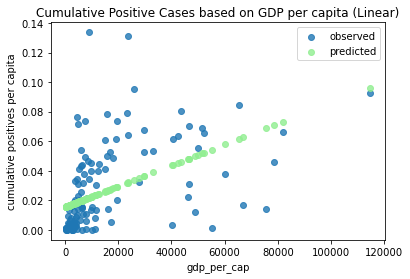

r squared: 0.242


In [10]:
pos_gdp_regressor = LinearRegression()

pos_gdp_reshapeX = np.reshape(covid_data[['gdp_per_cap']], (-1, 1))


pos_gdp_regressor.fit(pos_gdp_reshapeX, covid_data['cpos_norm'])

pos_gdp_pred = pos_gdp_regressor.predict(pos_gdp_reshapeX)

plt.scatter(pos_gdp_reshapeX, covid_data['cpos_norm'], alpha = 0.8)
plt.scatter(pos_gdp_reshapeX, pos_gdp_pred, c ='lightgreen', alpha = 0.8)
plt.title('Cumulative Positive Cases based on GDP per capita (Linear)')
plt.xlabel('gdp_per_cap')
plt.ylabel('cumulative positives per capita')
plt.legend(['observed', 'predicted'])

plt.show()
print("r squared: {:.3f}".format(pos_gdp_regressor.score(pos_gdp_reshapeX, covid_data['cpos_norm'])))


#### 2: Predict cumulative positive covid cases per capita (Y) based on gini index (X) (Linear Regression)

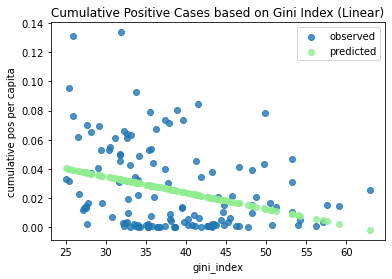

r squared: 0.10


In [11]:
pos_gini_regressor = LinearRegression()

pos_gini_reshapeX = np.reshape(covid_data[['gini_index']], (-1, 1))


pos_gini_regressor.fit(pos_gini_reshapeX, covid_data['cpos_norm'])

pos_gini_pred = pos_gini_regressor.predict(pos_gini_reshapeX)

plt.scatter(pos_gini_reshapeX, covid_data['cpos_norm'], alpha = 0.8)
plt.scatter(pos_gini_reshapeX, pos_gini_pred, c ='lightgreen', alpha = 0.8)
plt.title('Cumulative Positive Cases based on Gini Index (Linear)')
plt.xlabel('gini_index')
plt.ylabel('cumulative pos per capita')
plt.legend(['observed', 'predicted'])

plt.show()
print("r squared: {:.2f}".format(pos_gini_regressor.score(pos_gini_reshapeX, covid_data['cpos_norm'])))

#### 3: Predict cumulative positive covid cases per capita (Y) based on population density (X) (Linear Regression)

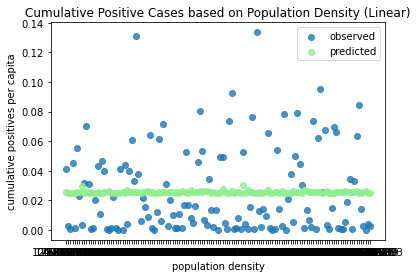

r squared: 0.0006


In [12]:
pos_den_regressor = LinearRegression()

pos_den_regressor.fit(covid_data[['pop_density']], covid_data['cpos_norm'])

pos_den_pred = pos_den_regressor.predict(covid_data[['pop_density']])

%matplotlib inline
plt.scatter(covid_data['pop_density'], covid_data['cpos_norm'], alpha = 0.8)
plt.scatter(covid_data['pop_density'], pos_den_pred, c ='lightgreen', alpha = 0.8)
plt.title('Cumulative Positive Cases based on Population Density (Linear)')
plt.xlabel('population density')
plt.ylabel('cumulative positives per capita')
plt.legend(['observed', 'predicted'])
plt.show()
print("r squared: {:.4f}".format(pos_den_regressor.score(covid_data[['pop_density']], covid_data['cpos_norm'])))

#### 4: Predict cumulative positive covid cases per capita (Y) based on unemployment rates (X) (Linear Regression)

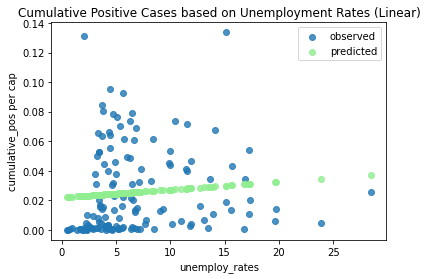

r squared: 0.0083


In [13]:
pos_rates_regressor = LinearRegression()

pos_rates_regressor.fit(covid_data[['unemploy_rates']], covid_data['cpos_norm'])

pos_rates_pred = pos_rates_regressor.predict(covid_data[['unemploy_rates']])

plt.scatter(covid_data[['unemploy_rates']], covid_data['cpos_norm'], alpha = 0.8)
plt.scatter(covid_data[['unemploy_rates']], pos_rates_pred, c ='lightgreen', alpha = 0.8)
plt.title('Cumulative Positive Cases based on Unemployment Rates (Linear)')
plt.xlabel('unemploy_rates')
plt.ylabel('cumulative_pos per cap')
plt.legend(['observed', 'predicted'])

plt.show()
print("r squared: {:.4f}".format(pos_rates_regressor.score(covid_data[['unemploy_rates']], covid_data['cpos_norm'])))

#### 5: Using GDP per capita, gini index, population density, and unemployment rates to predict the cumulative positive COVID cases per capita

In [14]:
multi_model = LinearRegression()
multi_model.fit(covid_data[['gdp_per_cap', 'gini_index', 'pop_density','unemploy_rates']], covid_data['cpos_norm'])
print('gdp_per_cap coefficient: {:.3E}'.format(multi_model.coef_[0]))
print('gini_index coefficient: {:.3E}'.format(multi_model.coef_[1]))
print('population density coefficient: {:.3E}'.format(multi_model.coef_[2]))
print('unemployment rates coefficient: {:.3E}'.format(multi_model.coef_[3]))

score = multi_model.score(covid_data[['gdp_per_cap', 'gini_index', 'pop_density','unemploy_rates']], covid_data['cpos_norm'])
print('r^2 score: {:.4f}'.format(score))

gdp_per_cap coefficient: 6.376E-07
gini_index coefficient: -7.082E-04
population density coefficient: -4.363E-07
unemployment rates coefficient: 1.140E-03
r^2 score: 0.2982


#### 6: Using GDP per capita, gini index, population density, and unemployment rates to predict covid deaths per capita

In [15]:
multi_model_dec = LinearRegression()
multi_model_dec.fit(covid_data[['gdp_per_cap', 'gini_index', 'pop_density','unemploy_rates']], covid_data['cdec_norm'])
print('gdp_per_cap coefficient: {:.3E}'.format(multi_model_dec.coef_[0]))
print('gini_index coefficient: {:.3E}'.format(multi_model_dec.coef_[1]))
print('population density coefficient: {:.3E}'.format(multi_model_dec.coef_[2]))
print('unemployment rates coefficient: {:.3E}'.format(multi_model_dec.coef_[3]))

score_dec = multi_model_dec.score(covid_data[['gdp_per_cap', 'gini_index', 'pop_density','unemploy_rates']], covid_data['cdec_norm'])
print('r^2 score: {:.4f}'.format(score_dec))

gdp_per_cap coefficient: 1.026E-08
gini_index coefficient: -1.194E-05
population density coefficient: -1.663E-07
unemployment rates coefficient: 1.954E-05
r^2 score: 0.1914


#### 7: Using GDP per capita, gini index, population density, and unemployment rates to predict ratio of covid deaths to covid positives

In [16]:
multi_model_ratio = LinearRegression()
multi_model_ratio.fit(covid_data[['gdp_per_cap', 'gini_index', 'pop_density','unemploy_rates']], covid_data['dec_pos_ratio'])


print('gdp_per_cap coefficient: {:.3E}'.format(multi_model_ratio.coef_[0]))
print('gini_index coefficient: {:.3E}'.format(multi_model_ratio.coef_[1]))
print('population density coefficient: {:.3E}'.format(multi_model_ratio.coef_[2]))
print('unemployment rates coefficient: {:.3E}'.format(multi_model_ratio.coef_[3]))

score_ratio = multi_model_ratio.score(covid_data[['gdp_per_cap', 'gini_index', 'pop_density','unemploy_rates']], covid_data['dec_pos_ratio'])
print('r^2 score: {:.4f}'.format(score_ratio))

gdp_per_cap coefficient: -3.696E-08
gini_index coefficient: 1.007E-04
population density coefficient: -5.800E-06
unemployment rates coefficient: 6.896E-05
r^2 score: 0.0244
